In [1]:
import proplot as pplt
import numpy as np
import xarray as xr
import dask
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import glob
import dask.array as da
from metpy.units import units
from scipy import stats
from scipy.stats import linregress

In [2]:
data_hist_ssp245_MPI_ESM  = '/work/mh0033/m301036/LSAT/CMIP6-MPI-M-LR/MergeDataOut/tas_Amon_1850-2022_*.nc'

ds = xr.open_mfdataset(data_hist_ssp245_MPI_ESM, combine = 'nested', concat_dim = 'run')
ds

<xarray.Dataset>
Dimensions:    (time: 2076, run: 30, bnds: 2, lon: 180, lat: 90)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2022-12-16T12:00:00
  * lon        (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
    height     float64 2.0
Dimensions without coordinates: run, bnds
Data variables:
    time_bnds  (run, time, bnds) datetime64[ns] dask.array<chunksize=(1, 2076, 2), meta=np.ndarray>
    tas        (run, time, lat, lon) float32 dask.array<chunksize=(1, 2076, 90, 180), meta=np.ndarray>
Attributes: (12/49)
    CDI:                    Climate Data Interface version 2.0.3 (https://mpi...
    source:                 MPI-ESM1.2-LR (2017): \naerosol: none, prescribed...
    institution:            Max Planck Institute for Meteorology, Hamburg 201...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    ...                     ...
    variable_id:            tas
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by MPI-M is licensed un...
    cmor_version:           3.5.0
    tracking_id:            hdl:21.14100/6b679cba-17b8-45eb-90dc-23d170c1998c
    CDO:                    Climate Data Operators version 2.0.3 (https://mpi...

In [3]:
#Perfrom land sea mask
land_sea_mask=xr.open_dataset('/work/mh0033/m301036/LSAT/CMIP6-MPI-M-LR/GR15_lsm_regrid.nc')
# land_sea_mask.coords
display(land_sea_mask)
# land_sea_mask.coords

<xarray.Dataset>
Dimensions:  (time: 1, lon: 180, lat: 90)
Coordinates:
  * time     (time) float64 201.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
Data variables:
    var1     (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.0.6 (https://mpimet.mpg.de...
    Conventions:  CF-1.0
    history:      Sun May 14 21:24:57 2023: cdo remapbil,r180x90 /pool/data/M...
    CDO:          Climate Data Operators version 2.0.6 (https://mpimet.mpg.de...

In [4]:
mask_data = land_sea_mask['var1']
mask_data
# Align the time coordinates between the mask dataset and the original dataset
time_values = pd.to_datetime(mask_data['time'].values, format='mixed', dayfirst=True)
mask_data['time'] = time_values

# Align the time coordinates between the mask dataset and the original dataset
mask_data = mask_data.reindex(time=ds['time'], method='nearest')

# Apply the land-sea mask to the original dataset
masked_tas = ds.where(mask_data == 1, drop=False)

masked_tas

<xarray.Dataset>
Dimensions:    (run: 30, time: 2076, bnds: 2, lat: 90, lon: 180)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2022-12-16T12:00:00
  * lon        (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
    height     float64 2.0
Dimensions without coordinates: run, bnds
Data variables:
    time_bnds  (run, time, bnds, lat, lon) datetime64[ns] dask.array<chunksize=(1, 2076, 2, 90, 180), meta=np.ndarray>
    tas        (run, time, lat, lon) float32 dask.array<chunksize=(1, 2076, 90, 180), meta=np.ndarray>
Attributes: (12/49)
    CDI:                    Climate Data Interface version 2.0.3 (https://mpi...
    source:                 MPI-ESM1.2-LR (2017): \naerosol: none, prescribed...
    institution:            Max Planck Institute for Meteorology, Hamburg 201...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    ...                     ...
    variable_id:            tas
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by MPI-M is licensed un...
    cmor_version:           3.5.0
    tracking_id:            hdl:21.14100/6b679cba-17b8-45eb-90dc-23d170c1998c
    CDO:                    Climate Data Operators version 2.0.3 (https://mpi...

In [5]:
tas = masked_tas['tas'].loc[:,'1850-01-01':'2022-12-31',:,:]
tas = tas - 273.15
tas_climatology = tas.groupby('time.month').mean(dim='time')
tas_ano = tas.groupby('time.month') - tas_climatology
tas_ano
lat = tas_ano['lat']
lon = tas_ano['lon']

/home/m/m301036/.conda/envs/mykernel/lib/python3.9/site-packages/xarray/core/indexing.py:1440: PerformanceWarning: Slicing with an out-of-order index is generating 173 times more chunks
  return self.array[key]


In [6]:
#Separate data into monthly and output as new nc file
time_data = tas_ano['time']
time_index = pd.to_datetime(time_data.values)
time_index

DatetimeIndex(['1850-01-16 12:00:00', '1850-02-15 00:00:00',
               '1850-03-16 12:00:00', '1850-04-16 00:00:00',
               '1850-05-16 12:00:00', '1850-06-16 00:00:00',
               '1850-07-16 12:00:00', '1850-08-16 12:00:00',
               '1850-09-16 00:00:00', '1850-10-16 12:00:00',
               ...
               '2022-03-16 12:00:00', '2022-04-16 00:00:00',
               '2022-05-16 12:00:00', '2022-06-16 00:00:00',
               '2022-07-16 12:00:00', '2022-08-16 12:00:00',
               '2022-09-16 00:00:00', '2022-10-16 12:00:00',
               '2022-11-16 00:00:00', '2022-12-16 12:00:00'],
              dtype='datetime64[ns]', length=2076, freq=None)

In [7]:
weights = np.cos(np.deg2rad(tas.lat))*xr.ones_like(tas['lon'])

In [8]:
tas_ano_weighted = tas_ano.weighted(weights)
# display(tas_ano_weighted)
tas_ano_weighted_mean = tas_ano_weighted.mean(dim=['lat','lon'])
tas_ano_weighted_mean

<xarray.DataArray 'tas' (run: 30, time: 2076)>
dask.array<truediv, shape=(30, 2076), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 2022-12-16T12:00:00
    height   (time) float64 2.0 2.0 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0 2.0 2.0
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: run

In [9]:
tas_ano_annual = tas_ano_weighted_mean.groupby('time.year').mean('time')
tas_ano_annual
# display(tas_ano_annual.min().values)
# tas_ano_annual.max().values

<xarray.DataArray 'tas' (run: 30, year: 173)>
dask.array<transpose, shape=(30, 173), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2018 2019 2020 2021 2022
Dimensions without coordinates: run

In [10]:
seasons = ['JJA', 'DJF']
season_means = {}

for season in seasons:
    if season == 'JJA':
        months = [6,7,8]
    elif season == 'DJF':
        months =[12,1,2]
    
    season_months = tas_ano.sel(time=tas.time.dt.month.isin(months),lat=slice(0,90))
    
    # Calculate the seasonal mean SAT anomalies
    season_mean_anomalies = (season_months * weights).mean(dim=['lat', 'lon']) / weights.mean(dim=['lat', 'lon'])
    
    # Store the seasonal mean in the dictionary
    season_means[season] = season_mean_anomalies

# Access the multiyear JJA mean SAT anomalies
    
JJA_tas = season_means['JJA']
DJF_tas = season_means['DJF']

JJA_tas

<xarray.DataArray (run: 30, time: 519)>
dask.array<truediv, shape=(30, 519), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1850-06-16 ... 2022-08-16T12:00:00
    height   (time) float64 2.0 2.0 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0 2.0 2.0
    month    (time) int64 6 7 8 6 7 8 6 7 8 6 7 8 6 ... 6 7 8 6 7 8 6 7 8 6 7 8
Dimensions without coordinates: run

In [11]:
DJF_tas_mean = DJF_tas.groupby('time.year').mean(dim='time')
DJF_tas_mean

<xarray.DataArray (run: 30, year: 173)>
dask.array<transpose, shape=(30, 173), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2018 2019 2020 2021 2022
Dimensions without coordinates: run

In [12]:
JJA_tas_mean = JJA_tas.groupby('time.year').mean(dim='time')
# JJA_tas_mean[0,:].values
JJA_tas_mean

<xarray.DataArray (run: 30, year: 173)>
dask.array<transpose, shape=(30, 173), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2018 2019 2020 2021 2022
Dimensions without coordinates: run

In [13]:
window_size =65
rolled = tas_ano_annual.rolling(year=65, center=True).construct("window_size")
rolled[0,:,:]

<xarray.DataArray 'tas' (year: 173, window_size: 65)>
dask.array<getitem, shape=(173, 65), dtype=float64, chunksize=(65, 65), chunktype=numpy.ndarray>
Coordinates:
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2018 2019 2020 2021 2022
Dimensions without coordinates: window_size

In [14]:
#mask 
nyears = 173
windows = 110
k=0
mask = np.zeros((windows, nyears))
for i in range(windows):
    mask[i,k:k+65]=1
    k=k+1

In [16]:
mask[0],mask[1]

windows = xr.DataArray(np.arange(0,110,1), dims='windows')
year = xr.DataArray(np.arange(1850, 2023,1), dims='year')
new_dims = {'windows': windows, 'year': year}
mask = xr.DataArray(mask,dims=('windows','year'), coords=new_dims)
type(mask)
display(mask)

<xarray.DataArray (windows: 110, year: 173)>
array([[1., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]])
Coordinates:
  * windows  (windows) int64 0 1 2 3 4 5 6 7 ... 102 103 104 105 106 107 108 109
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2018 2019 2020 2021 2022

In [17]:
tas_ano_annual= xr.DataArray(tas_ano_annual)
display(tas_ano_annual)
# tas_ano_annual_reshaped = tas_ano_annual.broadcast_like(mask)
masked_annual_tas = mask*tas_ano_annual
masked_annual_tas

<xarray.DataArray 'tas' (run: 30, year: 173)>
dask.array<transpose, shape=(30, 173), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2018 2019 2020 2021 2022
Dimensions without coordinates: run

<xarray.DataArray (windows: 110, year: 173, run: 30)>
dask.array<multiply, shape=(110, 173, 30), dtype=float64, chunksize=(110, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * windows  (windows) int64 0 1 2 3 4 5 6 7 ... 102 103 104 105 106 107 108 109
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2018 2019 2020 2021 2022
Dimensions without coordinates: run

In [21]:
#the data should be the masked_annual_tas
#  dim is the selected run
#  trend is the returning running 15 year trend with the dimension size '101'
def polyfit_run(data):
    trend = np.zeros(109)
    for i in range(109):
        trend[i] = np.polyfit(range(65), data[i,:][data[i,:] != 0], deg=1)[0]
    return trend

In [ ]:
window_size = 65

num_runs= 30
num_points  = 173
num_windows = num_points - window_size + 1 

trend = np.zeros((num_runs,num_windows))

for irun in range(30):
    trend[irun,:]=polyfit_run(masked_annual_tas.isel(run=irun).values)
  

In [ ]:
tas_ano_JJA= xr.DataArray(JJA_tas_mean)
display(tas_ano_JJA)
# tas_ano_annual_reshaped = tas_ano_annual.broadcast_like(mask)
masked_JJA_tas = mask*tas_ano_JJA
masked_JJA_tas

<xarray.DataArray (run: 30, year: 173)>
dask.array<transpose, shape=(30, 173), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2018 2019 2020 2021 2022
Dimensions without coordinates: run

<xarray.DataArray (windows: 110, year: 173, run: 30)>
dask.array<multiply, shape=(110, 173, 30), dtype=float64, chunksize=(110, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * windows  (windows) int64 0 1 2 3 4 5 6 7 ... 102 103 104 105 106 107 108 109
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2018 2019 2020 2021 2022
Dimensions without coordinates: run

In [20]:
tas_ano_DJF= xr.DataArray(DJF_tas_mean)
display(tas_ano_DJF)
# tas_ano_annual_reshaped = tas_ano_annual.broadcast_like(mask)
masked_DJF_tas = mask*tas_ano_DJF
masked_DJF_tas

<xarray.DataArray (run: 30, year: 123)>
dask.array<transpose, shape=(30, 123), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * year     (year) int64 1900 1901 1902 1903 1904 ... 2018 2019 2020 2021 2022
Dimensions without coordinates: run

<xarray.DataArray (windows: 59, year: 123, run: 30)>
dask.array<multiply, shape=(59, 123, 30), dtype=float64, chunksize=(59, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * windows  (windows) int64 0 1 2 3 4 5 6 7 8 9 ... 50 51 52 53 54 55 56 57 58
  * year     (year) int64 1900 1901 1902 1903 1904 ... 2018 2019 2020 2021 2022
Dimensions without coordinates: run

In [21]:
trend_JJA = np.zeros((num_runs,num_windows))

for irun in range(30):
    trend_JJA[irun,:]=polyfit_run(masked_JJA_tas.isel(run=irun).values)

In [22]:
trend_DJF = np.zeros((num_runs,num_windows))

for irun in range(30):
    trend_DJF[irun,:]=polyfit_run(masked_DJF_tas.isel(run=irun).values)

In [23]:
#Calculate the 15yr running trend time series
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import signal
from sklearn.linear_model import LinearRegression

In [24]:
#output 30 run annual mean SAT
# tas_ano_annual_np = tas_ano_annual['tas'].values
x = np.arange(1900,1959,1)
num_time_series = tas_ano_annual.shape[0]

#calculate the ensemble mean of the MPI-ESM-LR 
tas_annual_mean = tas_ano_annual.mean('run')
# tas_annual_mean.values

In [25]:
# print(min(tas_annual_mean))
# print(max(tas_annual_mean))

In [26]:
year = xr.DataArray(np.arange(1900,1959,1),dims='year')
print(len(year))
trend_mean = trend.mean((0))
trend_JJA_mean = trend_JJA.mean((0))
trend_DJF_mean = trend_DJF.mean((0))

trend_DJF_mean.shape
trend_mean = xr.DataArray(trend_mean,dims=('year'), coords={'year': year})
trend_JJA_mean = xr.DataArray(trend_JJA_mean,dims=('year'), coords={'year': year})
trend_DJF_mean = xr.DataArray(trend_DJF_mean,dims=('year'), coords={'year': year})

59


In [27]:
#input trend data
CRUTEMP_annual = np.genfromtxt(fname='/work/mh0033/m301036/josie/LSAT/1900-2022LSAT/Data-output/CRUTEMP_annual_NH_65yr_trend.txt',delimiter='\t', skip_header=1)
CRUTEMP_JJA = np.genfromtxt(fname='/work/mh0033/m301036/josie/LSAT/1900-2022LSAT/Data-output/CRUTEMP_JJA_NH_65yr_trend.txt',delimiter='\t', skip_header=1)
CRUTEMP_DJF = np.genfromtxt(fname='/work/mh0033/m301036/josie/LSAT/1900-2022LSAT/Data-output/CRUTEMP_DJF_NH_65yr_trend.txt',delimiter='\t', skip_header=1)
CRUTEMP_trend_annual = CRUTEMP_annual[:,1]
CRUTEMP_trend_JJA = CRUTEMP_JJA[:,1]
CRUTEMP_trend_DJF = CRUTEMP_DJF[:,1]

In [28]:
GISS_annual = np.genfromtxt(fname='/work/mh0033/m301036/josie/LSAT/1900-2022LSAT/Data-output/GISS_annual_NH_65yr_trend.txt',delimiter='\t', skip_header=1)
GISS_JJA = np.genfromtxt(fname='/work/mh0033/m301036/josie/LSAT/1900-2022LSAT/Data-output/GISS_JJA_NH_65yr_trend.txt',delimiter='\t', skip_header=1)
GISS_DJF = np.genfromtxt(fname='/work/mh0033/m301036/josie/LSAT/1900-2022LSAT/Data-output/GISS_DJF_NH_65yr_trend.txt',delimiter='\t', skip_header=1)
GISS_trend_annual = GISS_annual[:,1]
GISS_trend_JJA = GISS_JJA[:,1]
GISS_trend_DJF = GISS_DJF[:,1]

In [29]:
MLOST_annual = np.genfromtxt(fname='/work/mh0033/m301036/josie/LSAT/1900-2022LSAT/Data-output/MLOST_annual_NH_65yr_trend.txt',delimiter='\t', skip_header=1)
MLOST_JJA = np.genfromtxt(fname='/work/mh0033/m301036/josie/LSAT/1900-2022LSAT/Data-output/MLOST_JJA_NH_65yr_trend.txt',delimiter='\t', skip_header=1)
MLOST_DJF = np.genfromtxt(fname='/work/mh0033/m301036/josie/LSAT/1900-2022LSAT/Data-output/MLOST_DJF_NH_65yr_trend.txt',delimiter='\t', skip_header=1)
MLOST_trend_annual = MLOST_annual[:,1]
MLOST_trend_JJA = MLOST_JJA[:,1]
MLOST_trend_DJF = MLOST_DJF[:,1]

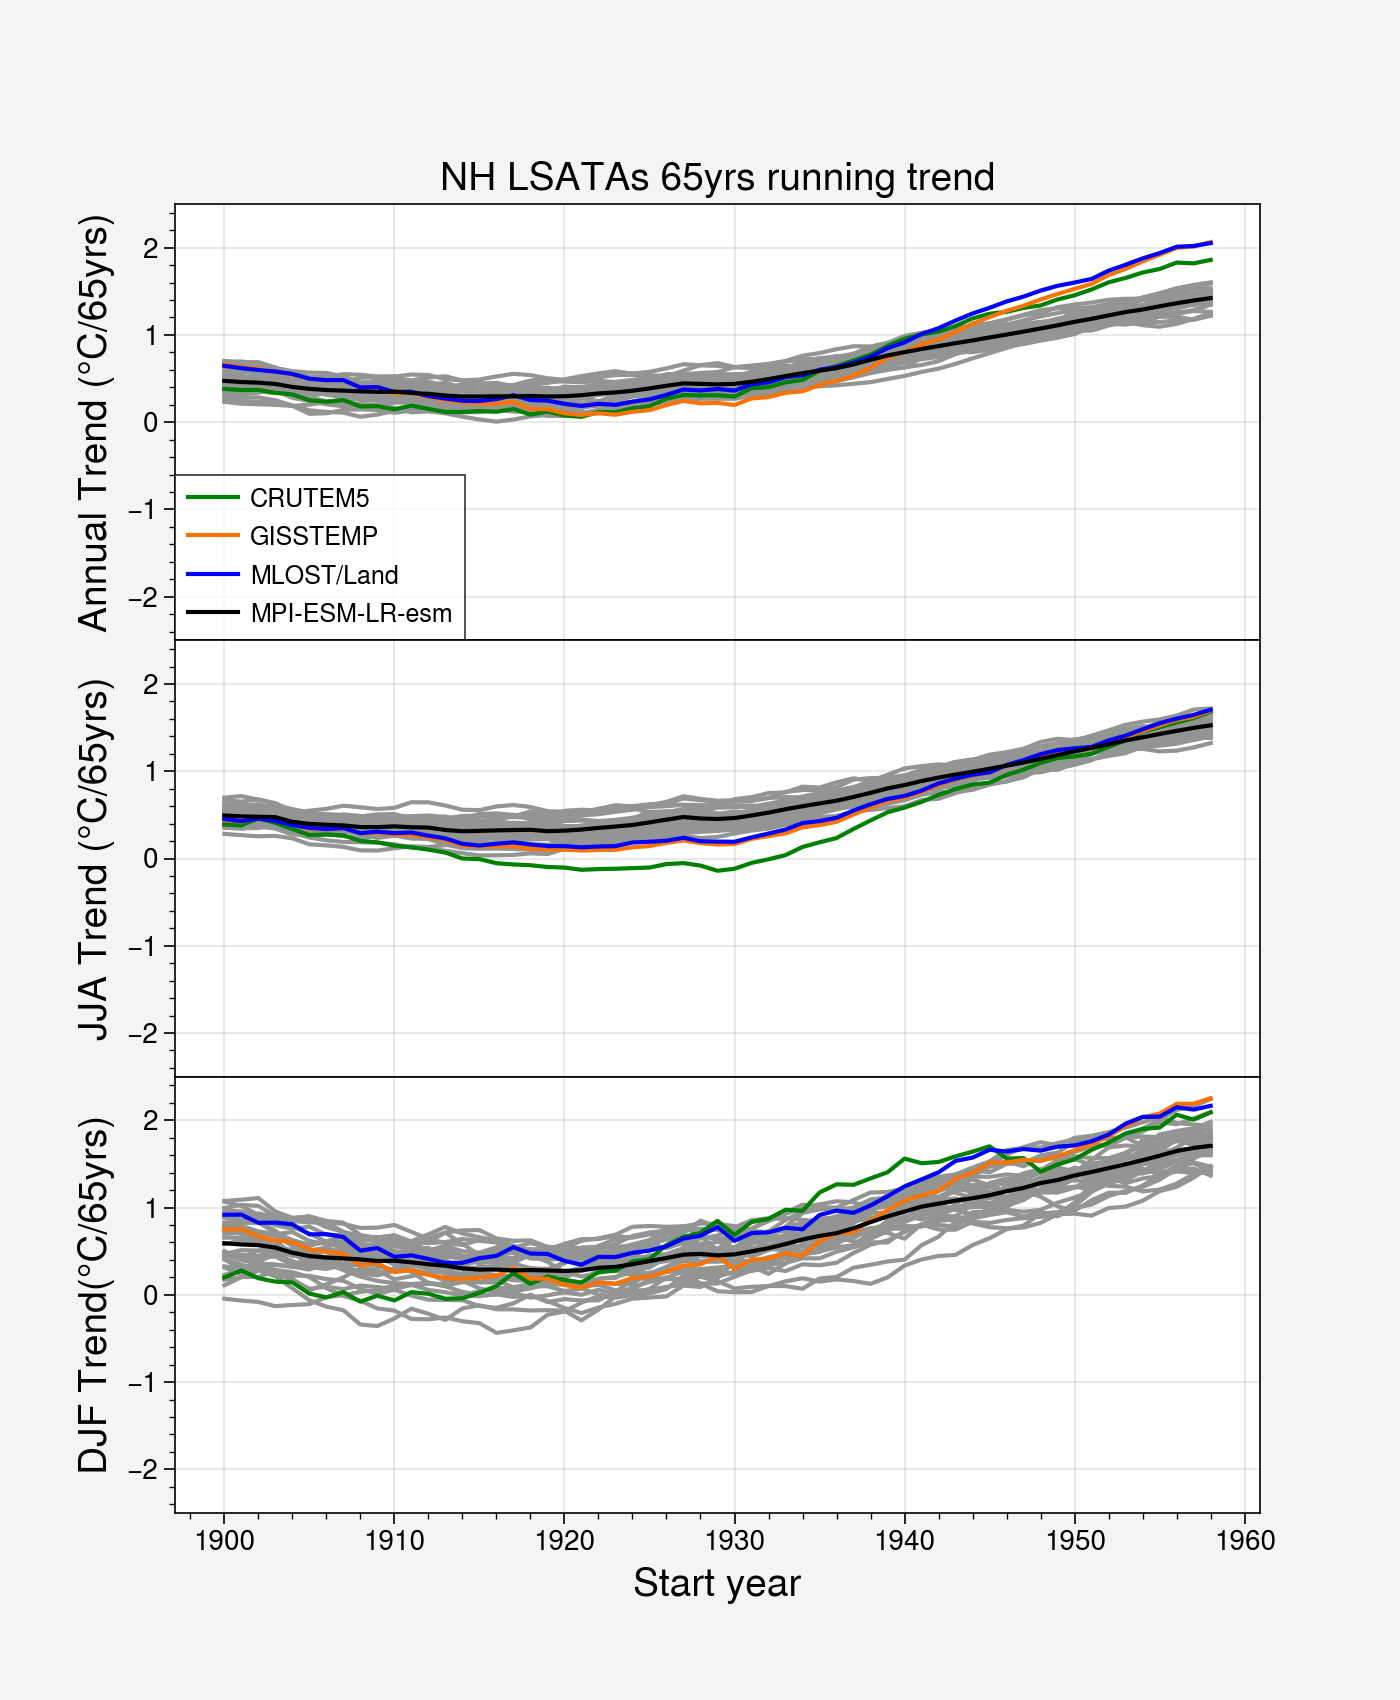

In [30]:
fig,axs = plt.subplots(3,1, figsize=(7,8.5), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0)

for i in range(num_time_series):
    axs[0].plot(x, trend[i, :]*65, color='gray')
    
axs[0].plot(x, CRUTEMP_trend_annual*65, color='green', label='CRUTEM5')
axs[0].plot(x, GISS_trend_annual*65, color='orange', label='GISSTEMP')
axs[0].plot(x, MLOST_trend_annual*65, color='blue', label='MLOST/Land')
axs[0].plot(x, trend_mean*65, color='black', label='MPI-ESM-LR-esm')
axs[0].set(ylim=(-2.5,2.5))
axs[0].set_title('NH LSATAs 65yrs running trend',fontsize=14)
axs[0].set_ylabel('Annual Trend (°C/65yrs)', fontsize=14)
axs[0].set_xlabel('Start year', fontsize=14)
# axs[0].grid(visible=False, which='major', axis='y')
axs[0].tick_params(axis='x', labelsize=10)
axs[0].tick_params(axis='y', labelsize=10)
axs[0].legend()
# Plot the JJA time series
for i in range(num_time_series):
    axs[1].plot(x, trend_JJA[i, :]*65, color='gray')

axs[1].plot(x, CRUTEMP_trend_JJA*65, color='green')
axs[1].plot(x, GISS_trend_JJA*65, color='orange')
axs[1].plot(x, MLOST_trend_JJA*65, color='blue')
axs[1].plot(x, trend_JJA_mean*65, color='black')
axs[1].set_ylabel('JJA Trend (°C/65yrs)', fontsize=14)
axs[1].set_xlabel('Start year', fontsize=14)
# axs[1].grid(visible=False, which='major', axis='y')
axs[1].tick_params(axis='x', labelsize=10)
axs[1].tick_params(axis='y', labelsize=10)

# Plot the DJF time series
for i in range(num_time_series):
    axs[2].plot(x, trend_DJF[i, :]*65, color='gray')
    
axs[2].plot(x, CRUTEMP_trend_DJF*65, color='green')
axs[2].plot(x, GISS_trend_DJF*65, color='orange')
axs[2].plot(x, MLOST_trend_DJF*65, color='blue')
axs[2].plot(x, trend_DJF_mean*65, color='black')
# axs[2].set_title('MPI-ESM1-LR 1850-2014 DJF SAT')
axs[2].set_ylabel('DJF Trend(°C/65yrs)', fontsize=14)
axs[2].set_xlabel('Start year', fontsize=14)
# axs[2].grid(visible=False, which='major', axis='y')
axs[2].tick_params(axis='x', labelsize=10)
axs[2].tick_params(axis='y', labelsize=10)

plt.show()

In [31]:
fig.savefig("./MPI-ESM-LR-NH_SATAs_65yr_running_trend.png")

## Extraction the 1958-2022 trend values

In [34]:
MLOST_DJF_trend = MLOST_trend_DJF[-1]*65.0
MLOST_DJF_trend = np.round(MLOST_DJF_trend, decimals=2)
print(MLOST_DJF_trend)

MLOST_JJA_trend = MLOST_trend_JJA[-1]*65.0
MLOST_JJA_trend = np.round(MLOST_JJA_trend, decimals=2)
print(MLOST_JJA_trend)

2.17
1.71


In [35]:
GISS_DJF_trend = GISS_trend_DJF[-1]*65.0
GISS_DJF_trend = np.round(GISS_DJF_trend, decimals=2)
print(GISS_DJF_trend)

GISS_JJA_trend = GISS_trend_JJA[-1]*65.0
GISS_JJA_trend = np.round(GISS_JJA_trend, decimals=2)
print(GISS_JJA_trend)

CRUTEMP_DJF_trend = CRUTEMP_trend_DJF[-1]*65.0
CRUTEMP_DJF_trend = np.round(CRUTEMP_DJF_trend, decimals=2)
print(CRUTEMP_DJF_trend)

CRUTEMP_JJA_trend = CRUTEMP_trend_JJA[-1]*65.0
CRUTEMP_JJA_trend = np.round(CRUTEMP_JJA_trend, decimals=2)
print(CRUTEMP_JJA_trend)

2.25
1.7
2.09
1.68


In [32]:
trend_30runs_DJF = pd.DataFrame({'run': np.arange(1,31,1), 'values': trend_DJF[:,-1]*65.0})
trend_30runs_DJF.to_csv('MPI-ESM-LR_NH_SATAs_65yr_DJF_trend.txt', sep='\t', index=False)

In [33]:
trend_30runs_JJA = pd.DataFrame({'run': np.arange(1,31,1), 'values': trend_JJA[:,-1]*65.0})
trend_30runs_JJA.to_csv('MPI-ESM-LR_NH_SATAs_65yr_JJA_trend.txt', sep='\t', index=False)

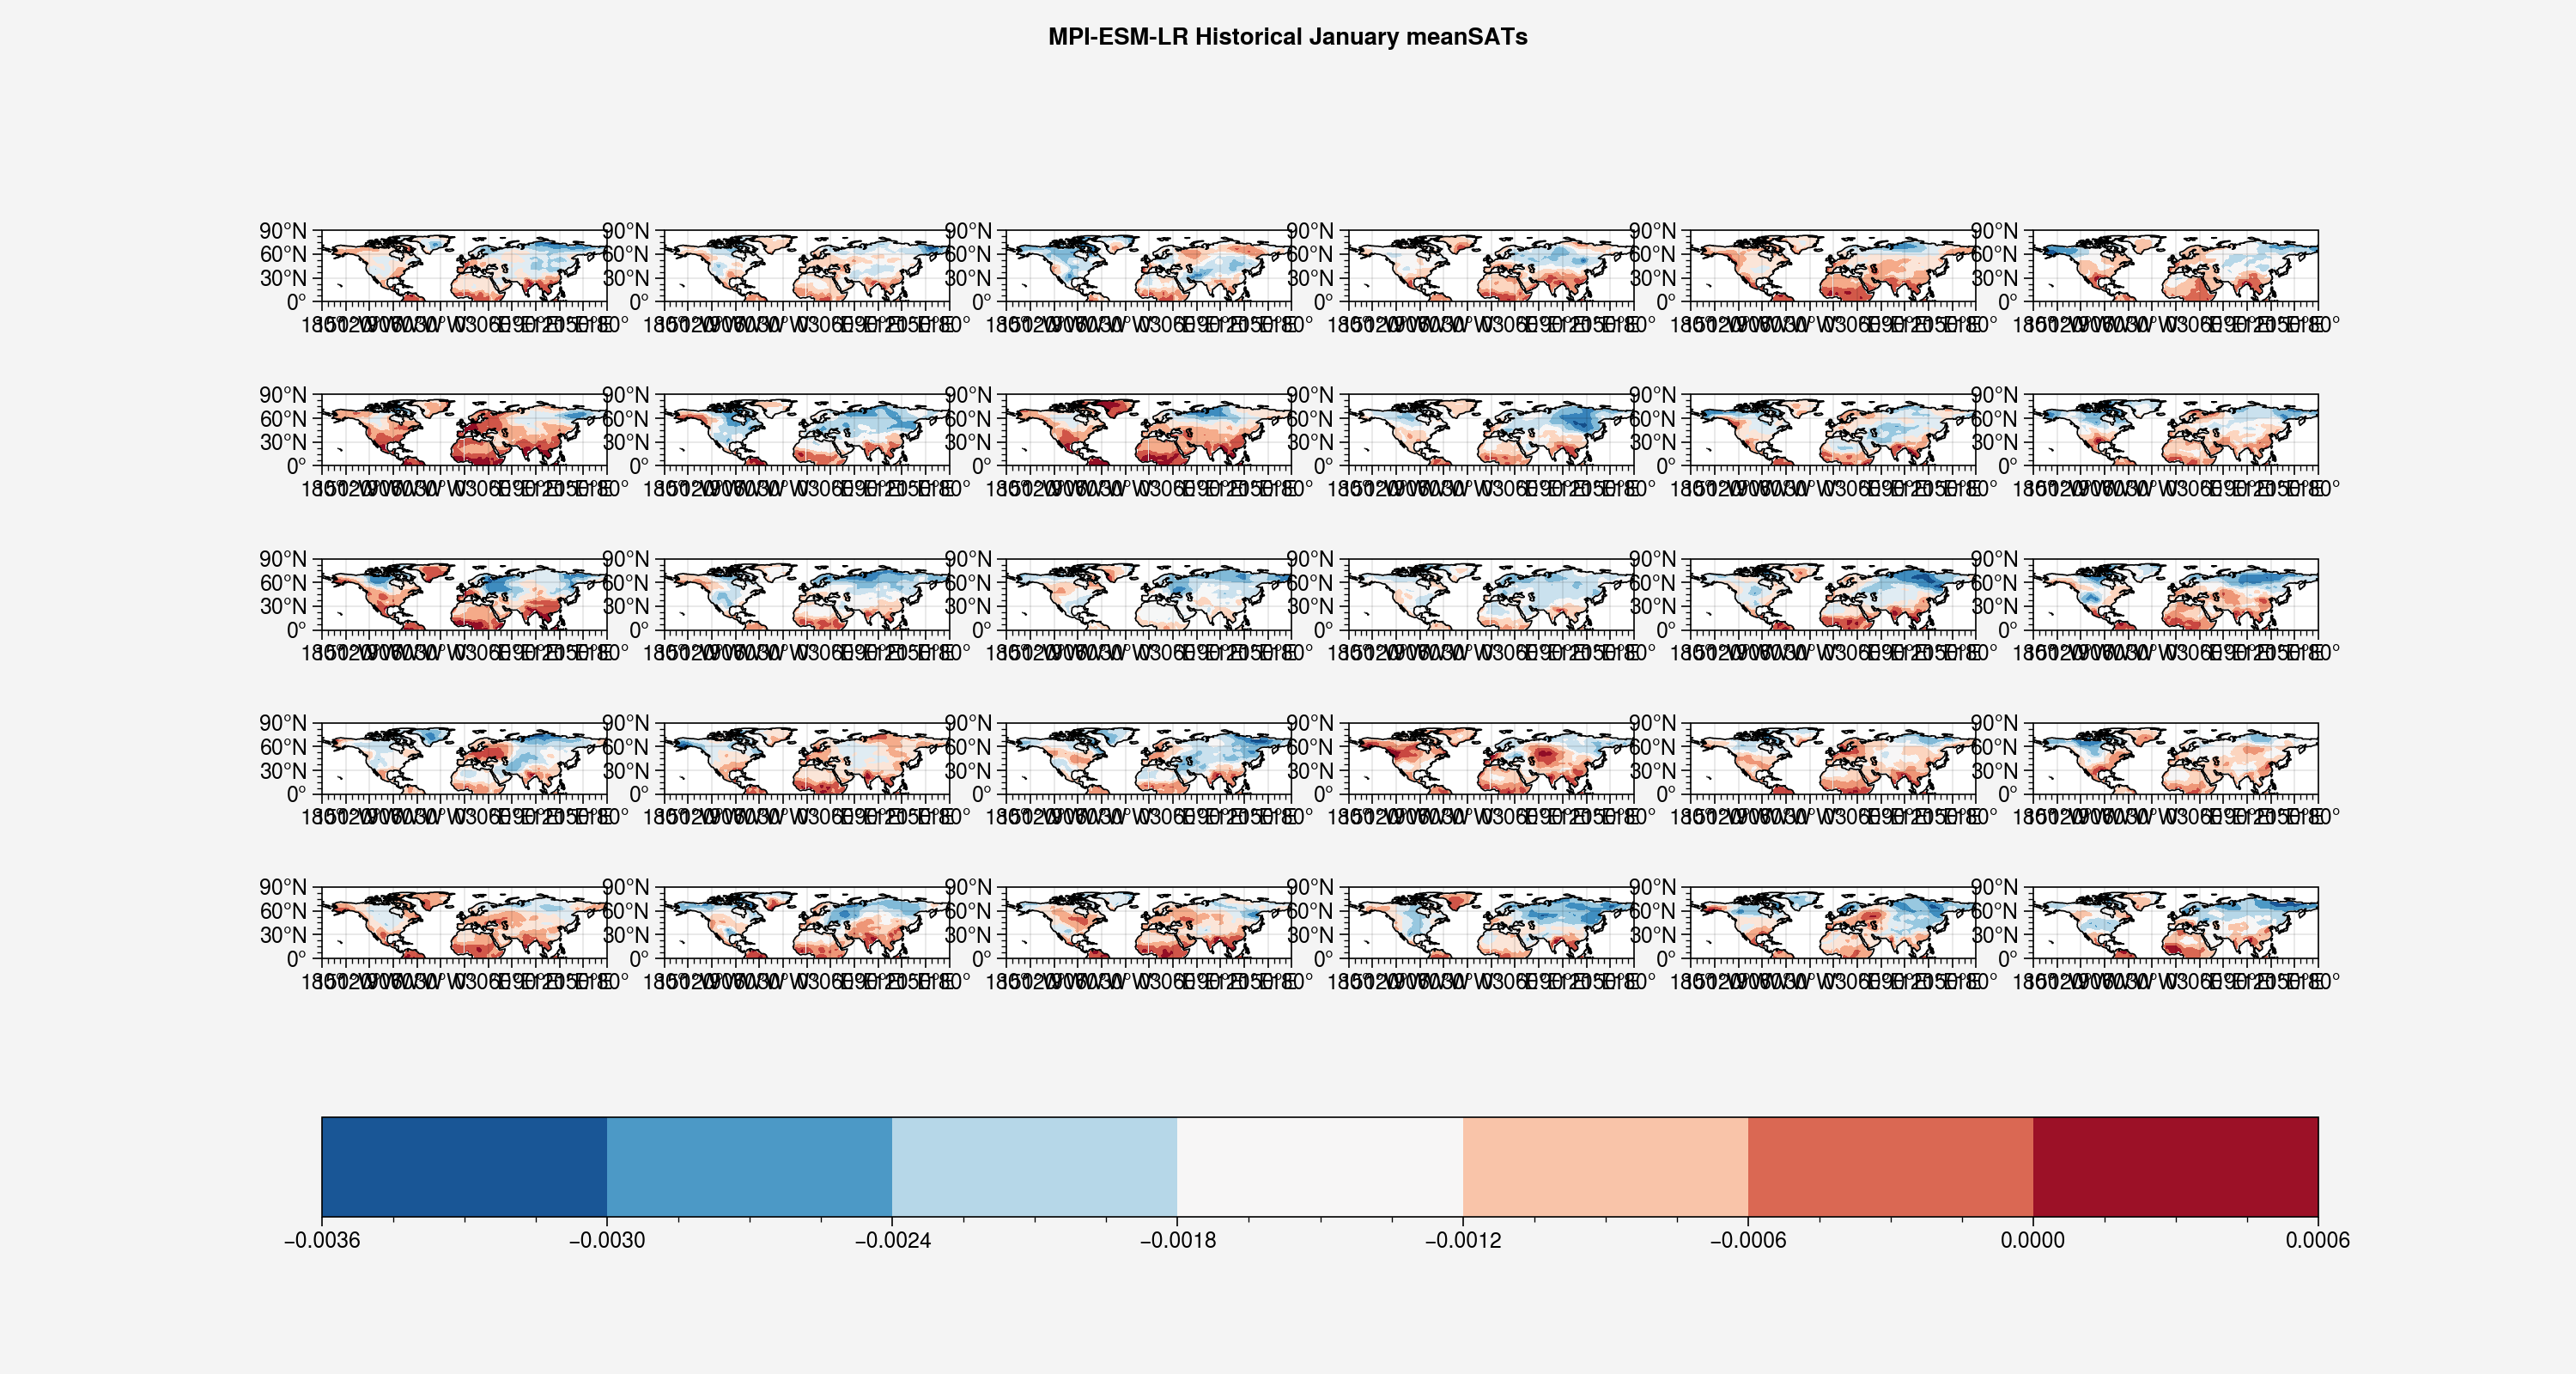

In [57]:

# import proplot as pplt
rows = 5
cols = 6

# create the figure and axes
projection = ccrs.PlateCarree()
fig, axs = plt.subplots(rows, cols, figsize=(15,8), subplot_kw={'projection':projection})
fig.suptitle('MPI-ESM-LR Historical January meanSATs')

# plot each model run
for i,ax in enumerate(axs.flat):
    mp=ax.contourf(lon, lat, annual_mean_anomalies[i, :, :], cmap='RdBu_r')#levels=np.arange(-30,30, 2.5)
    ax.set_xticks(np.arange(-180, 210, 30))#, crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(0, 120, 30))#, crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(cticker.LongitudeFormatter())
    ax.yaxis.set_major_formatter(cticker.LatitudeFormatter())
    ax.coastlines()
fig.colorbar(mp, ax=axs, orientation='horizontal', fraction=.1)
    
# add a legend and axis labels
# ax.legend()
# ax.set_xlabel('Time')
# ax.set_ylabel('Model Output')
# display the figure
plt.show()
# images = []
# for i in range(Nr):
#     for j in range(Nc):
#         # Generate data with a range that varies from one plot to the next.
#         data = tas_ano()
#         images.append(axs[i, j].imshow(data))
#         axs[i, j].label_outer()

# # Find the min and max of all colors for use in setting the color scale.
# vmin = min(image.get_array().min() for image in images)
# vmax = max(image.get_array().max() for image in images)
# norm = colors.Normalize(vmin=vmin, vmax=vmax)
# for im in images:
#     im.set_norm(norm)